In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Download dataset

In [ ]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("emmarex/plantdisease")
print("Path to dataset files:", path)

In [ ]:
Image_Size = 256
Batch_Size = 32
Epochs = 50
channels = 3

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"D:\Deep-Learning\potato_disease\dataset",
    labels='inferred',
    label_mode='int',
    seed = 123,
    batch_size=Batch_Size,
    image_size=(Image_Size, Image_Size),
    shuffle=True,
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
for image,labels in dataset.take(1):
    print(image.shape)
    print(labels.numpy())

(32, 256, 256, 3)
[1 1 0 1 0 1 1 1 1 0 2 1 1 0 1 0 0 1 0 0 1 1 1 2 1 0 1 1 1 0 0 0]


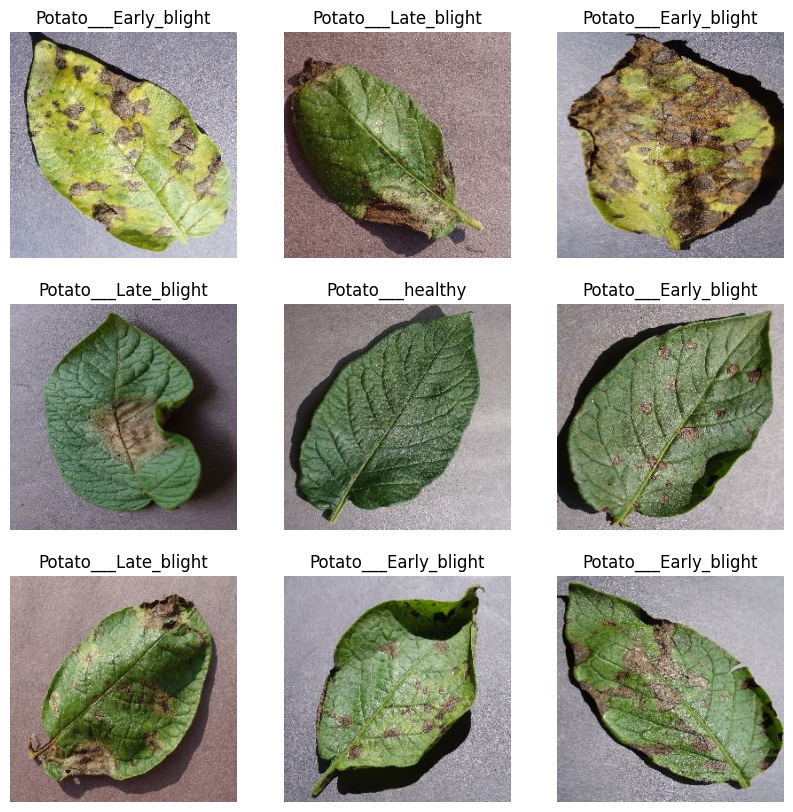

In [ ]:
plt.figure(figsize=(10, 10))
for image,labels in dataset.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, shuffle=True, shuffle_size=1000):
    
    ds_size = len(dataset)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(test_ds)

8

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
scaled_image = tf.keras.Sequential(
    [
        layers.Resizing(Image_Size, Image_Size),
        layers.Rescaling(1./255),
    ]
)

In [ ]:
data_augmentated = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

# Only apply on training data

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentated(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Directly apply augment in model

In [ ]:
n_classes = 3
input_shape = (Batch_Size,Image_Size, Image_Size, channels)
model = models.Sequential([
    scaled_image,
    data_augmentated,
    layers.Conv2D(32,(3,3),activation="relu",input_shape=input_shape),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation="relu",input_shape=(Batch_Size,Image_Size, Image_Size, channels)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation="relu",input_shape=(Batch_Size,Image_Size, Image_Size, channels)),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

In [ ]:

model.fit(
    train_ds,
    epochs=Epochs,
    batch_size=Batch_Size,
    validation_data=val_ds,
    verbose=1
    )

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.5447 - loss: 0.9194 - val_accuracy: 0.6823 - val_loss: 0.8954
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8231 - loss: 0.4474 - val_accuracy: 0.6719 - val_loss: 0.9862
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.8596 - loss: 0.3627 - val_accuracy: 0.8073 - val_loss: 0.5004
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8739 - loss: 0.2988 - val_accuracy: 0.8802 - val_loss: 0.3912
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9059 - loss: 0.2403 - val_accuracy: 0.9010 - val_loss: 0.2811
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9240 - loss: 0.2121 - val_accuracy: 0.8698 - val_loss: 0.3580
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9157 - loss: 0.2084 - val_accuracy: 0.9219 - val_loss: 0.2265
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9409 - loss: 0.1608 - val_accuracy: 0.8646 - val_loss:

In [ ]:
scores = model.evaluate(test_ds, verbose=1)
scores

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step - accuracy: 0.9239 - loss: 0.2096


[0.1653359830379486, 0.93359375]

Actual first_image to predict
Actual: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
Predicted: Potato___Early_blight


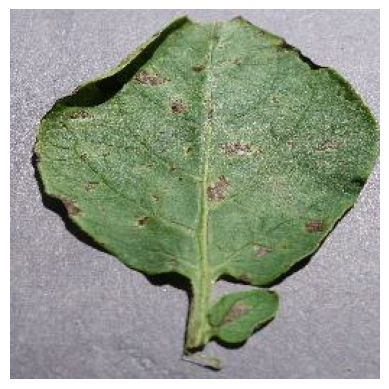

In [ ]:
for image , labels in test_ds.take(1):
    first_image = image[0].numpy().astype("uint8")
    first_labels = labels[0].numpy()

    print("Actual first_image to predict")
    plt.imshow(first_image)
    plt.axis("off")
    print("Actual:",class_names[first_labels])

    prediction = model.predict(image)
    print("Predicted:",class_names[numpy.argmax(prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


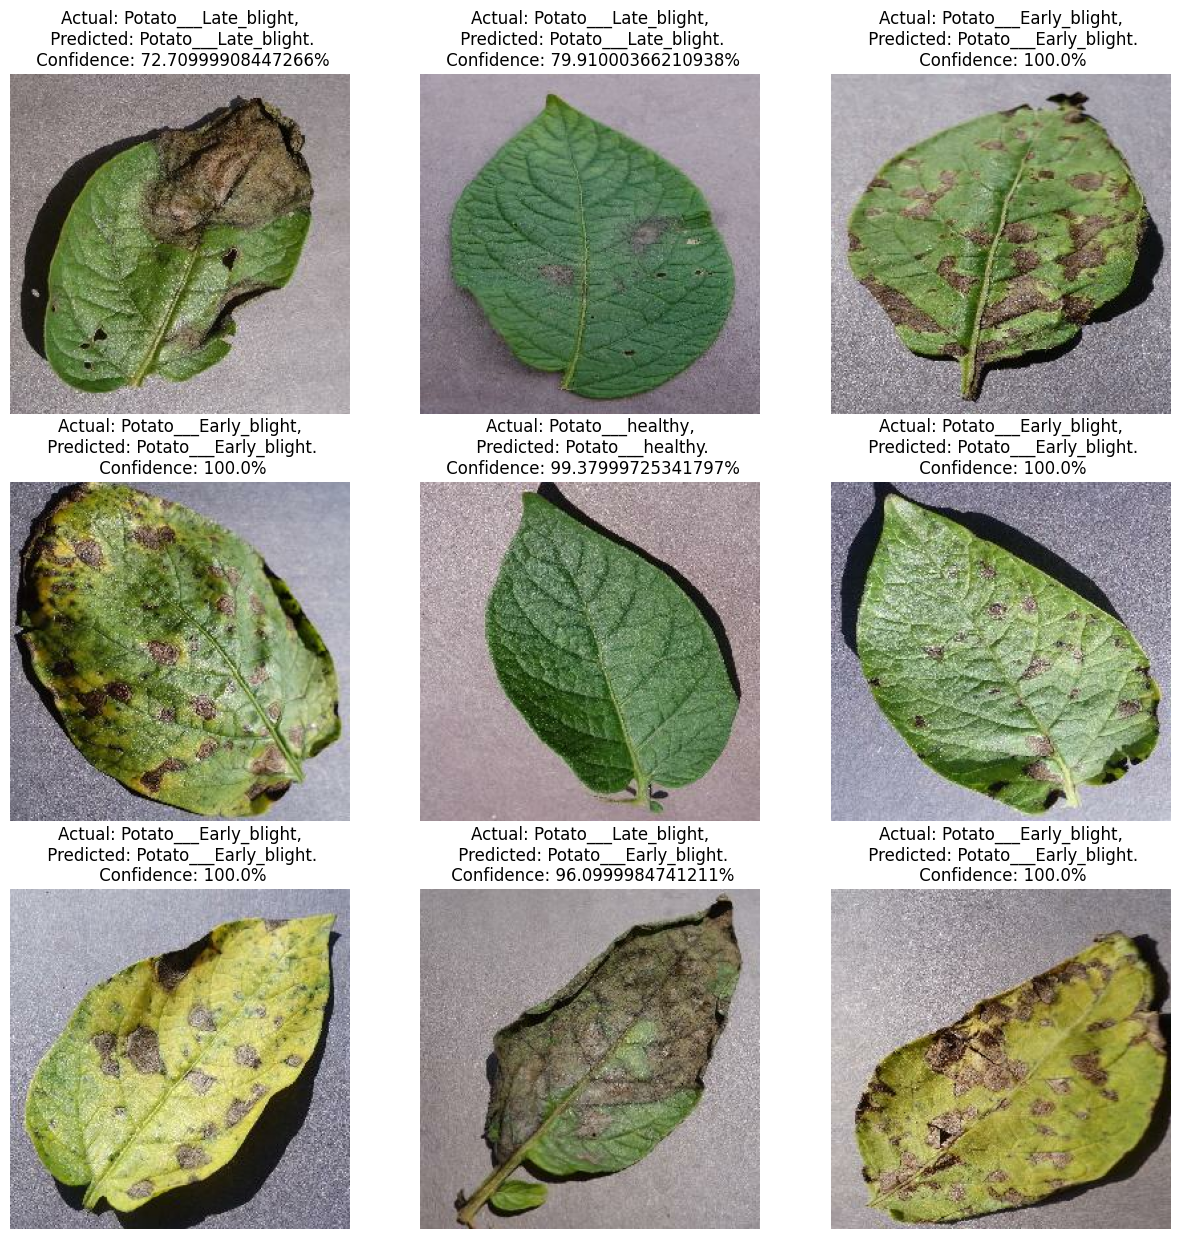

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
import os
os.getcwd()

'd:\\Deep-Learning\\potato_disease'

In [ ]:
save_path = f"d:/Deep-Learning/potato_disease/models/poteto_diseases.h5"
model.save(save_path)